# PyQuil implementation of the data-driven quantum circuit learning (DDQCL) algorithm 

Authors: Vicente Leyton-Ortega and Alejandro Perdomo-Ortiz
Rigetti Computing

Not for distribution or for public release. If interested in using or sharing beyond this group of the 2018 CDL QML cohort, please send an email to alejandro@rigetti.com for permissions.

Summary: Quick (and probably highly suboptimal) implementation of DDQCL in pyQuil/Forest


In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
#load the necessary packages and libs 
from pyquil.quil import Program   
import pyquil.api as api
from pyquil.gates import *
import numpy as np
import matplotlib.pyplot as plt
from random import *
import itertools


qvm = api.QVMConnection()   # to use the virtual machine
PRECISION = 8
CLIP = 1e-8


## Bars & Stripes data set 

### Here we consider $n \times m$ data set

In [4]:
def bars_and_stripes(rows, cols):
    
    data = [] 
    
    for h in itertools.product([0,1], repeat=cols):
        pic = np.repeat([h], rows, 0)
        data.append(pic.ravel().tolist())
          
    for h in itertools.product([0,1], repeat=rows):
        pic = np.repeat([h], cols, 1)
        data.append(pic.ravel().tolist())
    
    data = np.unique(np.asarray(data), axis=0)
    
    return data

<IPython.core.display.Javascript object>


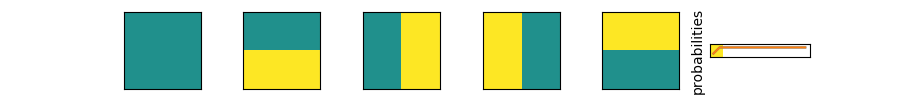

In [23]:
global n_qubits, hist_sample

n , m =  2, 2

bas = bars_and_stripes(n,m)

n_points, n_qubits  =  bas.shape

fig, ax = plt.subplots(1, bas.shape[0], figsize=(9,1))
for i in range(bas.shape[0]):
    ax[i].matshow(bas[i].reshape(n, m), vmin=-1, vmax=1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
'''sample distribution'''
hist_sample = [0 for _ in range(2**n_qubits)]
for s in bas:
    b = ''.join(str(int(e)) for e in s)
    idx = int(b, 2)
    hist_sample[idx]  += 1./float(n_points) 


### Topologies 

<IPython.core.display.Javascript object>


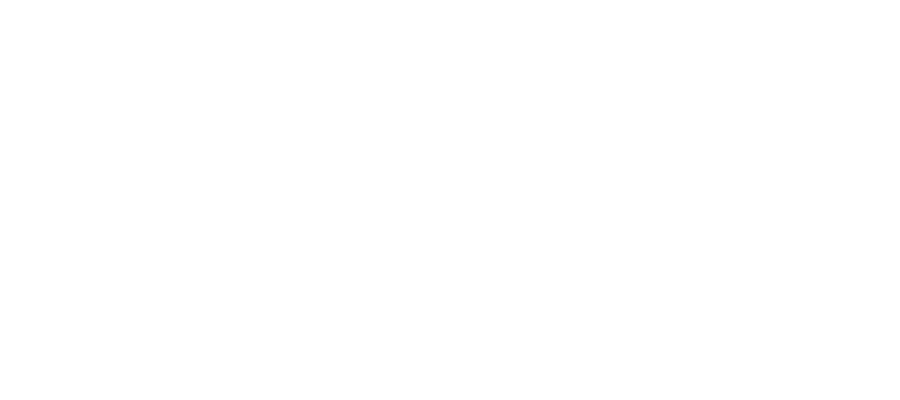

In [6]:
import networkx as nx 

edges_all_connected = []
edges_star          = []
edges_line          = []

''' line topology'''
for i in range(n_qubits-1):
    connections = [i,i+1]
    edges_line.append(connections)


'''star topology'''
for i in range(1,n_qubits):
    connections = [0,i]
    edges_star.append(connections)


'''all connected topology'''
for i in range(n_qubits-1):
    for j in range(i+1,n_qubits):
        connections = [i,j]
        edges_all_connected.append(connections)

# Or build any other you would like to explore. For example, ring topology?
        
        
'''lets define a little function for the connections'''
def top(x):
    if x == 0:
        edges = edges_line
    if x == 1: 
        edges = edges_star
    if x == 2:
        edges = edges_all_connected
    return edges

'''lets plot the different configuratios'''

options = {
           'node_color': 'orange',
           'node_size': 300,
           'width': 1}

fig =  plt.figure(figsize=(9,4))

graph_line = nx.Graph(top(0))
ax1 = fig.add_subplot(131)
ax1.set_title('line')
nx.draw_shell(graph_line, with_labels = True, **options)

graph_star = nx.Graph(top(1))
ax2 = fig.add_subplot(132)
ax2.set_title('star')
nx.draw_shell(graph_star, with_labels = True, **options)

graph_all_connected = nx.Graph(top(2))
ax3 = fig.add_subplot(133)
ax3.set_title('all connected')
nx.draw_shell(graph_all_connected,with_labels = True, **options)

### Circuit parameters

In [7]:
global n_top, single_g, entangling_g, n_layers, dimension
global min_bounds, max_bounds, n_rotations

'''define the topology'''
n_top = 2        # options: 0 - line, 1 - star,  2 - all connected 

'''define single and entangling gates'''
init_single_g =  ['RY','RZ']
single_g      =  ['RY','RZ','RY']   
entangling_g  =  ['YY']       # options YY, ZZ, CPHASE -- the entangling gate can be modify in the circuit           

'''define the number of layers'''
n_layers = 2

'''angles'''
first_layer   = len(init_single_g)
n_rotations   = len(single_g)
even_n_layers = int(np.floor(n_layers/2))
odd_n_layers  = n_layers - even_n_layers
dimension     = (n_rotations*(odd_n_layers-1) + first_layer)*n_qubits + len(top(n_top))*even_n_layers #len(top(n_top)) is the number of edges in the graphs


### Circuit

In [8]:
def circuit(angles):
    
    C  = Program()
    for i in range(n_qubits):
        C.inst(I(i))           #here we are considering |00000000> as the input state. Options: Changing I to H applies Hadamards to all qubits and create a full superposition
    
   
    i = 0
    for qb in range(n_qubits) :
        for op in init_single_g: 
            x = angles[i]*np.pi  #rotating angles are written in units of pi 
            gate = (op + "("+str(x)+")",qb)
            C.inst(gate)
            i+=1                 #now it will call the next element in angles
    
    for ly in range(2, n_layers + 1):
        if ly % 2 == 1: #single gates are only in odd layers
            for qb in range(n_qubits):
                for op in single_g:
                    x = angles[i]*np.pi  #rotating angles are written in units of pi 
                    gate = (op + "("+str(x)+")",qb)
                    C.inst(gate)
                    
                    i+=1                 #now it will call the next element in angles
                                        
        else:
            for qb_qb in top(n_top):
                if entangling_g[0] == 'YY':
                    
                    x = angles[i]*np.pi/2.0 #entangling angles are written in units of 2*pi
                    idx1 = qb_qb[0]
                    idx2 = qb_qb[1]
                    
                    C.inst(CNOT(idx1,idx2))
                    C.inst(RY(2.0*x,idx2))
                    C.inst(CNOT(idx1,idx2))
                            
                    i+=1
                    
                elif entangling_g[0] == 'ZZ':  #ZZ(theta,1,2) = CNOT(1,2) RZ(2 theta,2) CNOT(1,2), - pi < 2 theta < pi
                    
                    x = angles[i]*np.pi/2.0    # theta = x*pi/2, then -1 < x < 1
                    idx1 = qb_qb[0]
                    idx2 = qb_qb[1]
                    
                    C.inst(CNOT(idx1,idx2))
                    C.inst(RZ(2.0*x,idx2))
                    C.inst(CNOT(idx1,idx2))
                    
                    i+=1
                    
                    
                                               ## we can define more entangling gates!
                else:
                    
                    x = angles[i]*np.pi/2.0
                    idx1 = qb_qb[0]
                    idx2 = qb_qb[1]
                    gate = (entangling_g[0] + "("+str(x)+")",idx1,idx2)
                    C.inst(gate)
                    
                    i+=1
                    
    
    qvm        =  api.QVMConnection()                
    wf         =  qvm.wavefunction(C)     #get the output circuit wavefunction
    probs_dist =  wf.get_outcome_probs()  #get the probability distribution --- be careful it is a dict
    probs      =  list(range(2**n_qubits))
    
    '''here we extract the distribution values from the dict'''
    for i in range(2**n_qubits):

        aa = str(np.binary_repr(i,n_qubits))[::-1]
        probs[i]=probs_dist[aa]
        
    assert(round(sum(probs), PRECISION)==1.)  # just to make sure 
    
        
    return probs
                    
                

### Kleiber - Leibler function

In [27]:
def KL(angles):
    probs = circuit(angles)
    
    l = 0.0
    for idx in range(2**n_qubits):
        l += -hist_sample[idx] * np.log(np.clip(probs[idx], CLIP, 1.)) \
                 + hist_sample[idx] * np.log(np.clip(hist_sample[idx], CLIP, 1.))    
    return l



In [ ]:
import numpy as np
from pyswarm import pso

In [30]:
angles = [np.random.randint(0, 180) for a in range(0,16) ]

L = KL(angles)
L

16.628921274724313

In [31]:
prob_target = [0 for i in range(0,16)]
prob_target[0] = 1
prob_target[3] = 1
prob_target[5] = 1
prob_target[12] = 1
prob_target[15] = 1

angles = [np.random.randint(0, 180) for a in range(0,16) ]

def objective(x, *args):
    angles = x
    return KL(angles)
    
lb = [-np.pi for i in range(0,16)]
ub = [np.pi for i in range(0,16)]
xopt = pso(objective, lb, ub, args=tuple(prob_target), swarmsize=5)

Stopping search: Swarm best objective change less than 1e-08


In [32]:
xopt

(array([ 0.49945423, -2.20852887,  0.90686544,  1.82309227, -2.56363966,
        -1.68428281, -1.34184301, -0.07045342,  1.58909338,  0.82719229,
        -1.4273842 ,  0.04717445,  0.60255   ,  2.37342581,  1.38598157,
         1.22715326]), 0.38489640318634866)

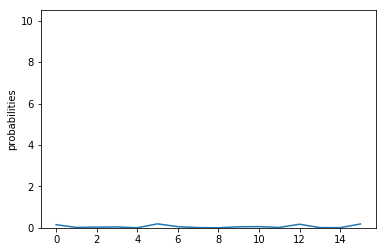

In [39]:
%matplotlib inline 
probs = circuit(xopt[0])
plt.plot(probs)
plt.plot(hist_sample)
plt.ylabel('probabilities')
plt.show()

In [ ]:
n , m =  2, 2

bas = bars_and_stripes(n,m)

n_points, n_qubits  =  bas.shape

fig, ax = plt.subplots(1, bas.shape[0], figsize=(9,1))
for i in range(bas.shape[0]):
    ax[i].matshow(bas[i].reshape(n, m), vmin=-1, vmax=1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
'''sample distribution'''
hist_sample = [0 for _ in range(2**n_qubits)]
for s in bas:
    b = ''.join(str(int(e)) for e in s)
    idx = int(b, 2)
    hist_sample[idx]  += 1./float(n_points) 